In [ ]:
# Microbiome Specific Power Analysis - Using Dummy Dataset
# By: Ashok K. Sharma
# Date: 04-08-2025

# We need to do the sample estimation again for cosidering three Groups.
#1. pregnant women with IBD who flare during pregnancy
#2. pregnant women with IBD who remain asymptoma􀆟c during pregnancy (do not meet criteria for disease flare during pregnancy)
#3. pregnant women without IBD
                                                                    
# I will be using this scirpt ("Final_PowerCalculation_Microbiome.ipynb") in which I did calculation using Two groups only - Dummy Data
# http://localhost:8888/notebooks/OneDrive%20-%20Cedars-Sinai%20Health%20System/Cedars2024_Work/Microbiome_Projects_Support/PujaKhanna_Proposal/Final_PowerCalculation_Microbiome.ipynb

Healthy            220
CD_flare           165
CD_asymptomatic    165
Name: Group, dtype: int64
Cohen's f: 0.433
Power for n=30 subjects: 0.761


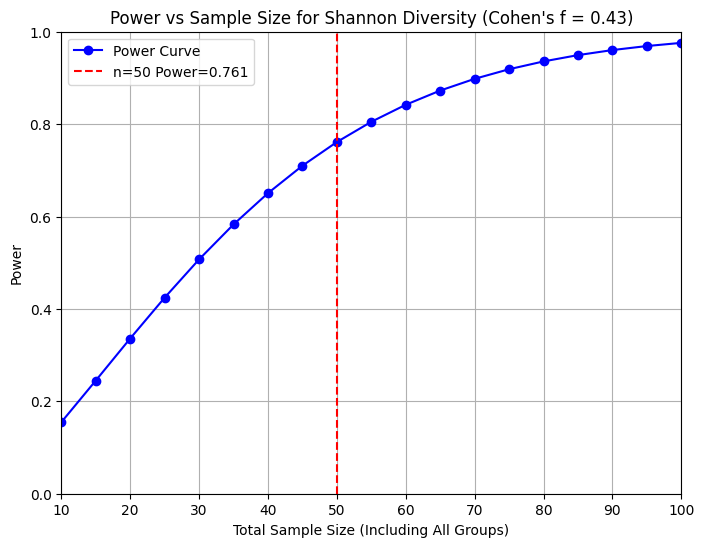

In [26]:
#1. This is to Sample Size Estimation for Repeated Measures

import numpy as np
import pandas as pd
from statsmodels.stats.power import FTestAnovaPower
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Set seed for reproducibility
np.random.seed(42)

# Function to simulate Shannon diversity data
def simulate_shannon_data(num_subjects=50, num_timepoints=11, effect_size=0.25):
    # Generate random group assignments for 3 groups
    groups = ['CD_flare', 'CD_asymptomatic', 'Healthy']
    group_assignments = np.random.choice(groups, size=num_subjects)

    # Generate Shannon diversity scores with a small effect between groups
    #mean_values = {'CD_flare': 3.5, 'CD_asymptomatic': 2.8, 'Healthy': 3.0}
    #mean_values = {'CD_flare': 3.5, 'CD_asymptomatic': 3.2, 'Healthy': 3.0}
    mean_values = {'CD_flare': 3.5, 'CD_asymptomatic': 2.9, 'Healthy': 2.5}
    std_dev = 0.6

    # Add effect size differences for each group
    shannon_values = []
    for group in group_assignments:
        group_mean = mean_values[group]
        values = np.random.normal(group_mean, std_dev, num_timepoints)
        shannon_values.extend(values)
    
    # Add subject IDs and timepoints
    subject_ids = np.repeat(np.arange(num_subjects), num_timepoints)
    timepoints = np.tile(np.arange(num_timepoints), num_subjects)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Subject_ID': subject_ids,
        'Time': timepoints,
        'Shannon': shannon_values,
        'Group': group_assignments.repeat(num_timepoints)
    })
    
    return df

# Generate data with 50 subjects and 11 timepoints per subject
num_subjects = 50
num_timepoints = 11
df = simulate_shannon_data(num_subjects=num_subjects, num_timepoints=num_timepoints)

print (df['Group'].value_counts())

# Compute effect size (Cohen's f) for the groups (CD_flare vs CD_asymptomatic vs Healthy)
group_data = [df.loc[df['Group'] == group, 'Shannon'] for group in df['Group'].unique()]
f_stat, p_val = f_oneway(*group_data)

# Compute Cohen's f from the F-statistic
cohen_f = np.sqrt(f_stat / (f_stat + len(df) - 3))  # k=3 groups
print(f"Cohen's f: {cohen_f:.3f}")

# Sample size estimation with 3 groups and 11 timepoints using FTestAnovaPower
alpha = 0.05
power_target = 0.8  # Target power of 0.8
k_groups = 3  # 3 groups

# Step 1: Calculate power for initial sample size (50 subjects)
analysis = FTestAnovaPower()
power_initial = analysis.solve_power(effect_size=cohen_f, alpha=alpha, power=None, k_groups=k_groups, nobs=num_subjects)
print(f"Power for n=30 subjects: {power_initial:.3f}")

# Step 2: Calculate power across a range of sample sizes
sample_sizes_range = np.arange(10, 150, 5)  # Example range of total sample sizes from 10 to 150
powers = [analysis.solve_power(effect_size=cohen_f, alpha=alpha, power=None, k_groups=k_groups, nobs=size) for size in sample_sizes_range]

# Step 3: Plotting the relationship between sample size and power
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes_range, powers, marker='o', linestyle='-', color='b', label='Power Curve')
plt.axvline(x=num_subjects, color='r', linestyle='--', label=f'n={num_subjects} Power={power_initial:.3f}')
plt.title(f'Power vs Sample Size for Shannon Diversity (Cohen\'s f = {cohen_f:.2f})')
plt.xlabel('Total Sample Size (Including All Groups)')
plt.ylabel('Power')
plt.xlim([10, 100])
plt.ylim([0, 1])
plt.grid(True)
plt.legend()
plt.show()

Healthy            220
CD_flare           165
CD_asymptomatic    165
Name: Group, dtype: int64
Cohen's f: 0.433
Design Effect: 4.600
Effective Sample Size (n=10 subjects × 11 timepoints): 23.9
Power with adjusted effective sample size: 0.405

Number of subjects per group needed to achieve 80% power: 24


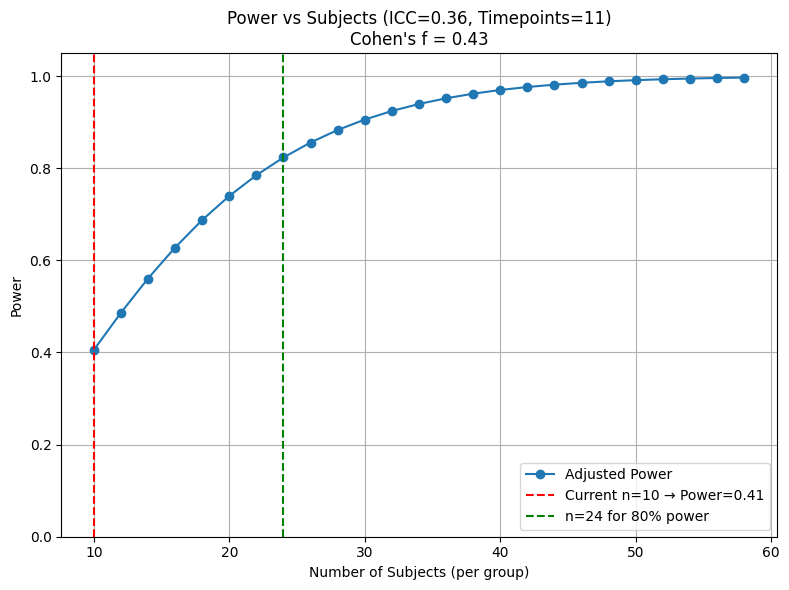

In [27]:
#2. This is to Sample Size Estimation for Repeated Measures - so incldue ICC values
import numpy as np
import pandas as pd
from statsmodels.stats.power import FTestAnovaPower
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# Set seed for reproducibility
np.random.seed(42)

# Parameters
n_subjects_sim = 50  # Simulate with 30 subjects per group
n_subjects_plot = 10  # Plot with 10 subjects per group (same as before)
num_timepoints = 11
icc = 0.36  # Intraclass Correlation Coefficient
alpha = 0.05
k_groups = 3

# Simulate Shannon diversity data for 3 groups
def simulate_shannon_data(n_subjects, num_timepoints):
    groups = ['CD_flare', 'CD_asymptomatic', 'Healthy']
    mean_vals = {'CD_flare': 3.5, 'CD_asymptomatic': 2.9, 'Healthy': 2.5}
    std_dev = 0.6

    subject_ids = np.arange(n_subjects)
    group_assignments = np.random.choice(groups, size=n_subjects)
    data = []

    for i, group in enumerate(group_assignments):
        values = np.random.normal(loc=mean_vals[group], scale=std_dev, size=num_timepoints)
        for t in range(num_timepoints):
            data.append([i, t, values[t], group])

    return pd.DataFrame(data, columns=['Subject_ID', 'Time', 'Shannon', 'Group'])

# Simulate data with n_subjects_sim (50 subjects per group)
df = simulate_shannon_data(n_subjects_sim, num_timepoints)

#df.to_csv("Simulated_data_Used.csv") # Don't save it again and again
print (df['Group'].value_counts())


# Calculate Cohen's f for effect size
group_data = [df[df['Group'] == g]['Shannon'] for g in df['Group'].unique()]
f_stat, _ = f_oneway(*group_data)
cohen_f = np.sqrt(f_stat / (f_stat + df.shape[0] - k_groups))
print(f"Cohen's f: {cohen_f:.3f}")

# Design effect and effective sample size
design_effect = 1 + (num_timepoints - 1) * icc
effective_n = (n_subjects_plot * num_timepoints) / design_effect  # Use n_subjects_plot for power calc
print(f"Design Effect: {design_effect:.3f}")
print(f"Effective Sample Size (n={n_subjects_plot} subjects × {num_timepoints} timepoints): {effective_n:.1f}")

# Power calculation for current sample size
analysis = FTestAnovaPower()
power_initial = analysis.solve_power(effect_size=cohen_f, alpha=alpha, power=None,
                                     k_groups=k_groups, nobs=effective_n)
print(f"Power with adjusted effective sample size: {power_initial:.3f}")

# Power curve over a range of subject counts (simulate for larger range)
subject_counts = np.arange(10, 60, 2)  # Range for subject counts
effective_ns = (subject_counts * num_timepoints) / design_effect
powers = [analysis.solve_power(effect_size=cohen_f, alpha=alpha, power=None,
                               k_groups=k_groups, nobs=neff) for neff in effective_ns]

# Determine required number of subjects to reach 80% power
target_power = 0.8
sufficient_n = next((n for n, p in zip(subject_counts, powers) if p >= target_power), None)

if sufficient_n:
    print(f"\nNumber of subjects per group needed to achieve 80% power: {sufficient_n}")
else:
    print("\n80% power not reached within the tested subject range.")

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(subject_counts, powers, marker='o', label='Adjusted Power')
plt.axvline(x=n_subjects_plot, color='r', linestyle='--', label=f'Current n={n_subjects_plot} → Power={power_initial:.2f}')
if sufficient_n:
    plt.axvline(x=sufficient_n, color='green', linestyle='--', label=f'n={sufficient_n} for 80% power')
plt.title(f'Power vs Subjects (ICC={icc}, Timepoints={num_timepoints})\nCohen\'s f = {cohen_f:.2f}')
plt.xlabel('Number of Subjects (per group)')
plt.ylabel('Power')
plt.ylim([0, 1.05])
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save figure
plt.tight_layout()
#plt.savefig("power_curve_shannon_ThreeGroups.png", dpi=300)
#plt.close()

plt.show()

In [28]:
# Importat to Check --> Repeated Measure ANOVA

CD_flare           550
CD_asymptomatic    550
Healthy            550
Name: Group, dtype: int64
Effect Size (Cohen's f): 1.066
Calculated ICC: 0.67

 Number of subjects per group needed to achieve 80% power: 24
Power at n=10: 0.411


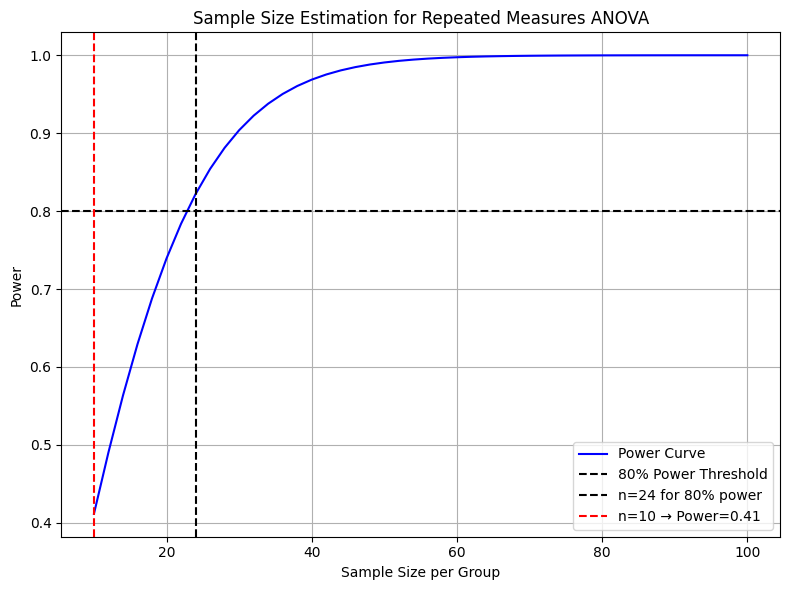

In [33]:
# Sample Size Estimation using Repeated Measure ANOVA
import numpy as np
import pandas as pd
from statsmodels.stats.power import FTestAnovaPower
import matplotlib.pyplot as plt

# Step 1: Simulate Shannon diversity data for 3 groups with repeated measures
def simulate_shannon_data(n_subjects=50, n_timepoints=11):
    np.random.seed(42)
    group_labels = ['CD_flare', 'CD_asymptomatic', 'Healthy']
    group_means = [3.5, 2.9, 2.5]
    group_sd = 0.4
    icc = 0.36  # for repeated measures

    data = []
    for i, group in enumerate(group_labels):
        for subj in range(n_subjects):
            subject_effect = np.random.normal(0, np.sqrt(icc) * group_sd)
            for t in range(n_timepoints):
                residual = np.random.normal(0, np.sqrt(1 - icc) * group_sd)
                shannon = group_means[i] + subject_effect + residual
                data.append((group, f"{group}_{subj}", t, shannon))

    df = pd.DataFrame(data, columns=["Group", "Subject_ID", "Timepoint", "Shannon"])
    return df


print(df['Group'].value_counts())

# Step 2: Compute effect size (Cohen's f)
def compute_cohens_f(df):
    group_means = df.groupby("Group")["Shannon"].mean()
    overall_mean = df["Shannon"].mean()
    n_groups = df["Group"].nunique()

    ss_between = sum(df[df["Group"] == g]["Shannon"].count() * (m - overall_mean) ** 2 
                     for g, m in group_means.items())
    ss_total = sum((df["Shannon"] - overall_mean) ** 2)
    eta_squared = ss_between / ss_total
    f = np.sqrt(eta_squared / (1 - eta_squared))
    return f

# Step 3: Estimate ICC
def compute_icc(df):
    subject_means = df.groupby("Subject_ID")["Shannon"].mean()
    grand_mean = df["Shannon"].mean()

    ss_between = sum((subject_means[s] - grand_mean) ** 2 * df[df["Subject_ID"] == s].shape[0]
                     for s in subject_means.index)

    ss_within = sum(((df[df["Subject_ID"] == s]["Shannon"] - subject_means[s]) ** 2).sum()
                    for s in subject_means.index)

    icc = ss_between / (ss_between + ss_within)
    return icc

# Step 4: Sample size and power estimation
def compute_power_by_sample_size(effect_size, icc, timepoints=11, alpha=0.05, power_threshold=0.8):
    adjusted_effect = effect_size * np.sqrt(1 / (1 + (timepoints - 1) * icc))
    power_model = FTestAnovaPower()
    sample_sizes = np.arange(10, 101, 2)
    powers = []

    for n in sample_sizes:
        power = power_model.solve_power(effect_size=adjusted_effect,
                                        nobs=n * 3,  # total across 3 groups
                                        alpha=alpha,
                                        power=None,
                                        k_groups=3)
        powers.append(power)

    # Determine minimal n for 80% power
    sufficient_n = next((n for n, p in zip(sample_sizes, powers) if p >= power_threshold), None)

    # Find the power at n=10
    power_at_n10_idx = np.where(sample_sizes == 10)[0][0]  # Find the index for n=10
    power_at_n10 = powers[power_at_n10_idx]  # Get the power value at n=10

    return sample_sizes, powers, sufficient_n, power_at_n10

# Step 5: Plotting
def plot_power_curve(sample_sizes, powers, sufficient_n, power_at_n10, power_threshold=0.8):
    plt.figure(figsize=(8, 6))
    plt.plot(sample_sizes, powers, label="Power Curve", color='blue')
    plt.axhline(power_threshold, color='black', linestyle='--', label="80% Power Threshold")
    plt.axvline(sufficient_n, color='black', linestyle='--', label=f'n={sufficient_n} for 80% power')
    plt.axvline(10, color='red', linestyle='--', label=f'n=10 → Power={power_at_n10:.2f}')  # Power at n=10
    plt.xlabel("Sample Size per Group")
    plt.ylabel("Power")
    plt.title("Sample Size Estimation for Repeated Measures ANOVA")
    plt.legend()
    plt.grid(True)
    # Save figure
    plt.tight_layout()
    #plt.savefig("Alternative_power_curve_shannon_ThreeGroups.png", dpi=300)
    #plt.close()
    plt.show()

# Running everything
df = simulate_shannon_data(n_subjects=50, n_timepoints=11)
f = compute_cohens_f(df)
icc = compute_icc(df)

print(f"Effect Size (Cohen's f): {f:.3f}")
print(f"Calculated ICC: {icc:.2f}")

sample_sizes, powers, sufficient_n, power_at_n10 = compute_power_by_sample_size(effect_size=f, icc=icc)
print(f"\n Number of subjects per group needed to achieve 80% power: {sufficient_n}")
print(f"Power at n=10: {power_at_n10:.3f}")

plot_power_curve(sample_sizes, powers, sufficient_n, power_at_n10)

In [ ]:
# Optional --> If ICC needs to be computed

Healthy            220
CD_flare           165
CD_asymptomatic    165
Name: Group, dtype: int64


/Users/sharmaa4/dataanalysis/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sharmaa4/dataanalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/sharmaa4/dataanalysis/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sharmaa4/dataanalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/sharmaa4/dataanalysis/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to con

Calculated ICC: 0.159
Design Effect: 2.592
Effective Sample Size (n=10 subjects × 11 timepoints): 42.4
Cohen's f: 0.433
Power with adjusted effective sample size: 0.681

 Number of subjects per group needed to achieve 80% power: 14


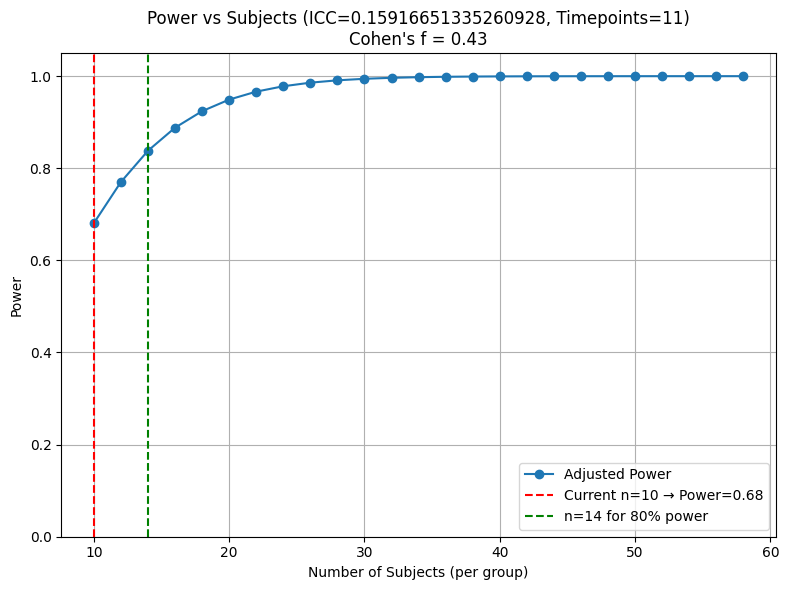

In [12]:
# If we need to Compute the ICC
import numpy as np
import pandas as pd
from statsmodels.stats.power import FTestAnovaPower
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set seed for reproducibility
np.random.seed(42)

# Parameters
n_subjects_sim = 50  # Simulate with 30 subjects per group
n_subjects_plot = 10  # Plot with 10 subjects per group (same as before)
num_timepoints = 11
icc = 0.36  # Intraclass Correlation Coefficient
alpha = 0.05
k_groups = 3

# Simulate Shannon diversity data for 3 groups
def simulate_shannon_data(n_subjects, num_timepoints):
    groups = ['CD_flare', 'CD_asymptomatic', 'Healthy']
    mean_vals = {'CD_flare': 3.5, 'CD_asymptomatic': 2.9, 'Healthy': 2.5}
    std_dev = 0.6

    subject_ids = np.arange(n_subjects)
    group_assignments = np.random.choice(groups, size=n_subjects)
    data = []

    for i, group in enumerate(group_assignments):
        values = np.random.normal(loc=mean_vals[group], scale=std_dev, size=num_timepoints)
        for t in range(num_timepoints):
            data.append([i, t, values[t], group])

    return pd.DataFrame(data, columns=['Subject_ID', 'Time', 'Shannon', 'Group'])

# Simulate data with n_subjects_sim (50 subjects per group)
df = simulate_shannon_data(n_subjects_sim, num_timepoints)

print (df['Group'].value_counts())

## Calculate ICC using linear mixed effects model (random effects model)
## ICC can be calculated from the variance components of the random effect (Subject_ID)
#model = smf.mixedlm("Shannon ~ Group", df, groups=df["Subject_ID"])
#result = model.fit()
#icc = result.cov_re.iloc[0, 0] / (result.cov_re.iloc[0, 0] + result.scale)
#print(f"Calculated ICC: {icc:.3f}")

# Linear mixed effects model with random slopes for Time
model = smf.mixedlm("Shannon ~ Group + Time", df, groups=df["Subject_ID"], re_formula="~Time")
result = model.fit()

# ICC Calculation
icc = result.cov_re.iloc[0, 0] / (result.cov_re.iloc[0, 0] + result.scale)
print(f"Calculated ICC: {icc:.3f}")

# Design effect and effective sample size
design_effect = 1 + (num_timepoints - 1) * icc
effective_n = (n_subjects_plot * num_timepoints) / design_effect
print(f"Design Effect: {design_effect:.3f}")
print(f"Effective Sample Size (n={n_subjects_plot} subjects × {num_timepoints} timepoints): {effective_n:.1f}")

# Calculate Cohen's f for effect size
group_data = [df[df['Group'] == g]['Shannon'] for g in df['Group'].unique()]
f_stat, _ = f_oneway(*group_data)
cohen_f = np.sqrt(f_stat / (f_stat + df.shape[0] - k_groups))
print(f"Cohen's f: {cohen_f:.3f}")

# Power calculation for current sample size
analysis = FTestAnovaPower()
power_initial = analysis.solve_power(effect_size=cohen_f, alpha=alpha, power=None,
                                     k_groups=k_groups, nobs=effective_n)
print(f"Power with adjusted effective sample size: {power_initial:.3f}")

# Power curve over a range of subject counts
subject_counts = np.arange(10, 60, 2)
effective_ns = (subject_counts * num_timepoints) / design_effect
powers = [analysis.solve_power(effect_size=cohen_f, alpha=alpha, power=None,
                               k_groups=k_groups, nobs=neff) for neff in effective_ns]

# Determine required number of subjects to reach 80% power
target_power = 0.8
sufficient_n = next((n for n, p in zip(subject_counts, powers) if p >= target_power), None)

if sufficient_n:
    print(f"\n Number of subjects per group needed to achieve 80% power: {sufficient_n}")
else:
    print("\n 80% power not reached within the tested subject range.")

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(subject_counts, powers, marker='o', label='Adjusted Power')
plt.axvline(x=n_subjects_plot, color='r', linestyle='--', label=f'Current n={n_subjects_plot} → Power={power_initial:.2f}')
if sufficient_n:
    plt.axvline(x=sufficient_n, color='green', linestyle='--', label=f'n={sufficient_n} for 80% power')
plt.title(f'Power vs Subjects (ICC={icc}, Timepoints={num_timepoints})\nCohen\'s f = {cohen_f:.2f}')
plt.xlabel('Number of Subjects (per group)')
plt.ylabel('Power')
plt.ylim([0, 1.05])
plt.grid(True)
plt.legend()

# Save figure
plt.tight_layout()
plt.savefig("power_curve_shannon_ThreeGroups_ComputedICC.png", dpi=300)
#plt.close()

plt.show()